# **Пункт 4**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("all_vacancies_clean.xlsx")

In [3]:
df.head()

,Unnamed: 0,id,name,company,city,key_skills,salary_from,salary_to,experience,schedule,alternate_url,salary,area,Vacancy type
0,0,114673345,BI-аналитик,ЛУКОЙЛ,Москва,"Power BI, Apache Airflow, SQL",150000,150000,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/114673345,150000,Мск_МО,BI-аналитик
1,1,117262495,Аналитик,Всм,Москва,"Контроль и анализ ценообразования, Unit-эконом...",80000,120000,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/117262495,100000,Мск_МО,Финансовый аналитик
2,2,116537974,Системный аналитик (junior+),ИТРУМ,Ростов-на-Дону,"Системный аналитик, UML, SQL, Функциональные т...",70000,80000,Нет опыта,Удаленная работа,https://hh.ru/vacancy/116537974,75000,ЮФО,Системный аналитик
3,3,117148794,Логист - аналитик маркетплейсов,Uniel,Москва,"Аналитическое мышление, Аналитика маркетплейсо...",80000,80000,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/117148794,80000,Мск_МО,Аналитик маркетплейсов
4,4,116518807,"Интервьюер (кастдэв, аналитика)",ЮДжейПи,Екатеринбург,"Телефонные переговоры, Коммуникабельность, Ана...",60000,60000,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/116518807,60000,УФО,Другое


Предобработка и подготовка данных

In [4]:
# Удаление экстремальных выбросов в salary (5-95 перцентили)
q_low = df['salary'].quantile(0.05)
q_high = df['salary'].quantile(0.95)
df_filtered = df[(df['salary'] >= q_low) & (df['salary'] <= q_high)].copy()

# Преобразуем key_skills
df_filtered['key_skills'] = df_filtered['key_skills'].fillna('').apply(lambda x: x.split(', ') if x else [])

# Отбор топ-30 навыков
skills_counts = Counter([skill for skills in df_filtered['key_skills'] for skill in skills if skill])
top_skills = [skill for skill, count in skills_counts.most_common(30)]
df_filtered['key_skills_top'] = df_filtered['key_skills'].apply(lambda x: [skill for skill in x if skill in top_skills])

# Новый признак: количество навыков
df_filtered['skills_count'] = df_filtered['key_skills'].apply(len)

# Агрегация средней зарплаты по company и area
company_avg_salary = df_filtered.groupby('company')['salary'].mean().to_dict()
area_avg_salary = df_filtered.groupby('area')['salary'].mean().to_dict()
df_filtered['company_avg_salary'] = df_filtered['company'].map(company_avg_salary).fillna(df_filtered['salary'].mean())
df_filtered['area_avg_salary'] = df_filtered['area'].map(area_avg_salary).fillna(df_filtered['salary'].mean())

# Ограничим число уникальных компаний (топ-100 + Other)
top_companies = df_filtered['company'].value_counts().head(100).index
df_filtered['company'] = df_filtered['company'].where(df_filtered['company'].isin(top_companies), 'Other')

# Кодирование
mlb = MultiLabelBinarizer()
key_skills_encoded = pd.DataFrame(mlb.fit_transform(df_filtered['key_skills_top']), columns=mlb.classes_, index=df_filtered.index)
experience_encoded = pd.get_dummies(df_filtered['experience'], prefix='experience')
schedule_encoded = pd.get_dummies(df_filtered['schedule'], prefix='schedule')
area_encoded = pd.get_dummies(df_filtered['area'], prefix='area')
company_encoded = pd.get_dummies(df_filtered['company'], prefix='company')

# Объединяем признаки
X = pd.concat([key_skills_encoded, experience_encoded, schedule_encoded, area_encoded, company_encoded,
               df_filtered[['skills_count', 'company_avg_salary', 'area_avg_salary']]], axis=1)
y = np.log1p(df_filtered['salary'])  # Логарифмическое преобразование

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 1. Удаление экстремальных выбросов в `salary` (5-95 перцентили)
- Определены нижний (5%) и верхний (95%) перцентили для столбца `salary` с помощью `quantile`.
- Данные фильтруются, исключая экстремальные значения, сохраняя 90% наблюдений.
- **Цель**: Уменьшить влияние аномалий на модель.

### 2. Преобразование `key_skills`
- Пропущенные значения в столбце `key_skills` заполняются пустыми списками (`fillna('')`).
- Строки преобразуются в списки навыков, разделяя по запятым с пробелом (`split(', ')`).
- **Цель**: Подготовка для кодирования навыков.

### 3. Отбор топ-30 навыков
- Частота каждого навыка подсчитывается с помощью `Counter`, выбираются 30 самых популярных (`most_common(30)`).
- Создается столбец `key_skills_top`, содержащий только эти навыки.
- **Цель**: Снижение размерности данных и устранение шума от редких навыков.

### 4. Новый признак: количество навыков
- Создается столбец `skills_count`, рассчитывающий количество навыков в каждом наблюдении через `apply(len)`.
- **Цель**: Отражение сложности вакансии или уровня квалификации.

### 5. Агрегация средней зарплаты по `company` и `area`
- Вычисляются средние зарплаты по компаниям (`company_avg_salary`) и федеральным округам (`area_avg_salary`) с помощью `groupby` и `mean()`.
- Пропущенные значения заполняются средним значением `salary` по всему набору данных.
- **Цель**: Добавление контекста рынка труда.
- **Комментарий**: Обогатил набор данных новыми агрегированными признаками, которые отражают средние зарплаты по компаниям и федеральным округам. Это улучшает предсказательную способность модели, сохраняя salary как целевую переменную для прогнозирования.

### 6. Ограничение числа уникальных компаний (топ-100 + Other)
- Выбираются 100 самых частых компаний с помощью `value_counts().head(100)`.
- Остальные заменяются категорией "Other" с помощью `where`.
- **Цель**: Уменьшение размерности, сохранение ключевых работодателей.

### 7. Кодирование
- **MultiLabelBinarizer** применяется для кодирования `key_skills_top` в бинарные столбцы для каждого навыка.
- `get_dummies` используется для one-hot кодирования категориальных признаков: `experience`, `schedule`, `area`, `company`.
- **Цель**: Преобразование категориальных переменных в числовой формат для модели.

### 8. Объединение признаков
- Все закодированные и новые признаки объединяются в единый `DataFrame` `X` с помощью `pd.concat`.
- Целевая переменная `y` преобразуется с помощью `np.log1p` для сглаживания масштаба зарплат.

### 9. Масштабирование признаков
- Применяется `StandardScaler` для нормализации признаков в `X_scaled`.
- **Цель**: Улучшение сходимости градиентных методов и работы линейных моделей.

### 10. Разделение данных
- Данные делятся на обучающую (80%) и тестовую (20%) выборки с помощью `train_test_split`, с фиксированным `random_state=42`.
- **Цель**: Обеспечение воспроизводимости и разделения для оценки модели.


Обучение модели

In [5]:
# Ridge-регрессия
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_test_pred_ridge = ridge.predict(X_test)

# Обратное преобразование для метрик
y_test_orig = np.expm1(y_test)
y_test_pred_orig_ridge = np.expm1(y_test_pred_ridge)

# Метрики для Ridge
test_mse_ridge = mean_squared_error(y_test_orig, y_test_pred_orig_ridge)
test_mae_ridge = mean_absolute_error(y_test_orig, y_test_pred_orig_ridge)
test_r2_ridge = r2_score(y_test_orig, y_test_pred_orig_ridge)

print("Метрики для Ridge-регрессии:")
print(f"Test MSE: {test_mse_ridge:.2f}")
print(f"Test MAE: {test_mae_ridge:.2f}")
print(f"Test R²: {test_r2_ridge:.4f}")

# Кросс-валидация для Ridge
cv_scores_ridge = cross_val_score(ridge, X_scaled, y, cv=5, scoring='r2')
print(f"Средний R² по 5-fold кросс-валидации (Ridge): {cv_scores_ridge.mean():.4f} (±{cv_scores_ridge.std() * 2:.4f})")

# XGBoost с GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_test_pred_xgb = best_model.predict(X_test)
y_test_pred_orig_xgb = np.expm1(y_test_pred_xgb)

# Метрики для XGBoost
test_mse_xgb = mean_squared_error(y_test_orig, y_test_pred_orig_xgb)
test_mae_xgb = mean_absolute_error(y_test_orig, y_test_pred_orig_xgb)
test_r2_xgb = r2_score(y_test_orig, y_test_pred_orig_xgb)

print("\nМетрики для лучшего XGBoost:")
print(f"Test MSE: {test_mse_xgb:.2f}")
print(f"Test MAE: {test_mae_xgb:.2f}")
print(f"Test R²: {test_r2_xgb:.4f}")

# Кросс-валидация для XGBoost
cv_scores_xgb = cross_val_score(best_model, X_scaled, y, cv=5, scoring='r2')
print(f"Средний R² по 5-fold кросс-валидации (XGBoost): {cv_scores_xgb.mean():.4f} (±{cv_scores_xgb.std() * 2:.4f})")

# Значимость признаков
coefficients_ridge = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("\nНаиболее значимые признаки для Ridge-регрессии:")
print(coefficients_ridge.head(10))

importances_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nНаиболее значимые признаки для лучшего XGBoost:")
print(importances_xgb.head(10))

Метрики для Ridge-регрессии:
Test MSE: 212112601.31
Test MAE: 8280.05
Test R²: 0.8055
Средний R² по 5-fold кросс-валидации (Ridge): 0.8422 (±0.0357)
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}

Метрики для лучшего XGBoost:
Test MSE: 121306867.47
Test MAE: 6642.84
Test R²: 0.8888
Средний R² по 5-fold кросс-валидации (XGBoost): 0.9032 (±0.0459)

Наиболее значимые признаки для Ridge-регрессии:
                                               Feature  Coefficient
150                                 company_avg_salary     0.317441
31                                experience_Нет опыта    -0.023978
114                                        company_РБК    -0.020960
51                                       company_Aston     0.017236
16                                Маркетинговый анализ     0.013174
32                       experience_От 1 года до 3 лет     0.012940
149                                       skills_count    -0.012681
90             company_Крас

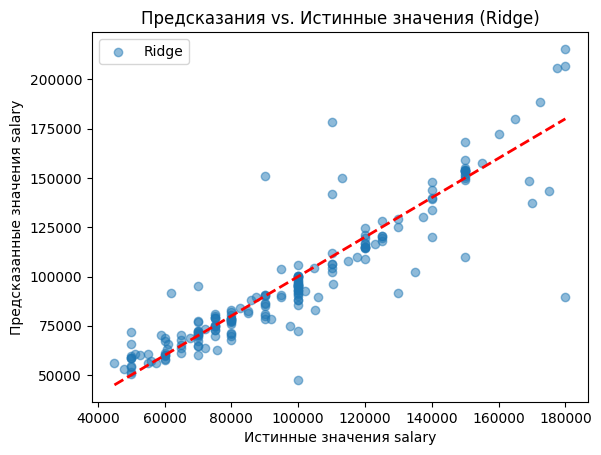

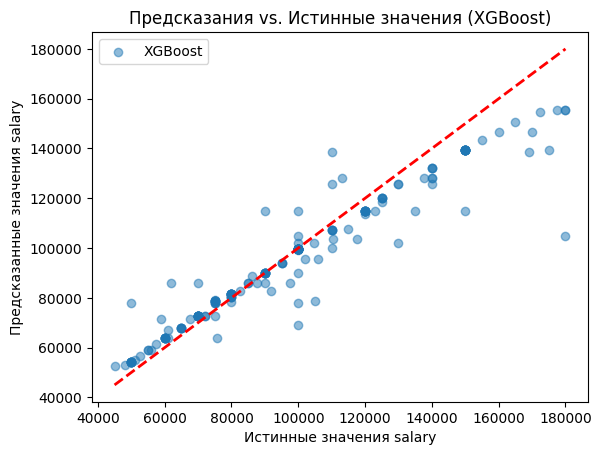

In [6]:
# График предсказаний vs. истинных значений для Ridge
plt.scatter(y_test_orig, y_test_pred_orig_ridge, alpha=0.5, label='Ridge')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.title('Предсказания vs. Истинные значения (Ridge)')
plt.legend()
plt.show()

# График предсказаний vs. истинных значений для XGBoost
plt.scatter(y_test_orig, y_test_pred_orig_xgb, alpha=0.5, label='XGBoost')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.title('Предсказания vs. Истинные значения (XGBoost)')
plt.legend()
plt.show()

Улучшение качества

In [7]:
# Предобработка
q_low = df['salary'].quantile(0.05)
q_high = df['salary'].quantile(0.95)
df_filtered = df[(df['salary'] >= q_low) & (df['salary'] <= q_high)].copy()

df_filtered['key_skills'] = df_filtered['key_skills'].fillna('').apply(lambda x: x.split(', ') if x else [])
skills_counts = Counter([skill for skills in df_filtered['key_skills'] for skill in skills if skill])
top_skills = [skill for skill, count in skills_counts.most_common(30)]
df_filtered['key_skills_top'] = df_filtered['key_skills'].apply(lambda x: [skill for skill in x if skill in top_skills])

df_filtered['skills_count'] = df_filtered['key_skills'].apply(len)
company_avg_salary = df_filtered.groupby('company')['salary'].mean().to_dict()
area_avg_salary = df_filtered.groupby('area')['salary'].mean().to_dict()
df_filtered['company_avg_salary'] = df_filtered['company'].map(company_avg_salary).fillna(df_filtered['salary'].mean())
df_filtered['area_avg_salary'] = df_filtered['area'].map(area_avg_salary).fillna(df_filtered['salary'].mean())

top_companies = df_filtered['company'].value_counts().head(100).index
df_filtered['company'] = df_filtered['company'].where(df_filtered['company'].isin(top_companies), 'Other')

mlb = MultiLabelBinarizer()
key_skills_encoded = pd.DataFrame(mlb.fit_transform(df_filtered['key_skills_top']), columns=mlb.classes_, index=df_filtered.index)
experience_encoded = pd.get_dummies(df_filtered['experience'], prefix='experience')
schedule_encoded = pd.get_dummies(df_filtered['schedule'], prefix='schedule')
area_encoded = pd.get_dummies(df_filtered['area'], prefix='area')
company_encoded = pd.get_dummies(df_filtered['company'], prefix='company')

X = pd.concat([key_skills_encoded, experience_encoded, schedule_encoded, area_encoded, company_encoded,
               df_filtered[['skills_count', 'company_avg_salary', 'area_avg_salary']]], axis=1)
y = df_filtered['salary']  # Без логарифма, используем MinMaxScaler позже

# Масштабирование с MinMaxScaler для целевой переменной
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# GridSearchCV для XGBoost
param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5]
}
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_test_pred_scaled = best_model.predict(X_test)

# Обратное преобразование для метрик
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_test_pred_orig = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

test_mse = mean_squared_error(y_test_orig, y_test_pred_orig)
test_mae = mean_absolute_error(y_test_orig, y_test_pred_orig)
test_r2 = r2_score(y_test_orig, y_test_pred_orig)

print("\nМетрики для лучшего XGBoost (с MinMaxScaler):")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.4f}")

# Кросс-валидация
cv_scores = cross_val_score(best_model, X_scaled, y_scaled, cv=5, scoring='r2')
print(f"Средний R² по 5-fold кросс-валидации: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")

# Значимость признаков
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nНаиболее значимые признаки для лучшего XGBoost:")
print(importances.head(10))

Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

Метрики для лучшего XGBoost (с MinMaxScaler):
Test MSE: 93701255.18
Test MAE: 4680.35
Test R²: 0.9141
Средний R² по 5-fold кросс-валидации: 0.9083 (±0.0360)

Наиболее значимые признаки для лучшего XGBoost:
                                               Feature  Importance
150                                 company_avg_salary    0.657124
117                                 company_Ростелеком    0.037429
22                 Работа с большим объемом информации    0.025752
31                                experience_Нет опыта    0.024844
6                            Анализ бизнес показателей    0.024393
35                                schedule_Полный день    0.023054
13                             Аналитический склад ума    0.019656
101  company_Национальный исследовательский универс...    0.018720
23                      Разработка технических заданий    0.018285
7                              Анализ бизнес

## Оптимизация модели

- Заменили логарифмическое преобразование `np.log1p` на `MinMaxScaler` для целевой переменной `salary`.  
  **Цель**: Обеспечить лучшее масштабирование данных.

- Добавили `GridSearchCV` для оптимизации гиперпараметров XGBoost:  
  - Параметры: `n_estimators`, `learning_rate`, `max_depth`.  
  **Цель**: Найти оптимальные значения гиперпараметров.

- Увеличили диапазон параметров:  
  - `n_estimators` до 300.  
  - `learning_rate` до 0.1.  
  - `max_depth` до 5.  
  **Цель**: Расширить пространство поиска для улучшения модели.

- Выполнили обратное преобразование метрик для оценки в исходном масштабе.  

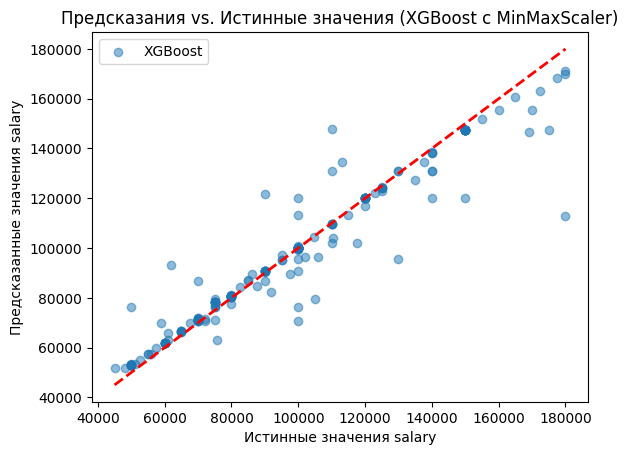

In [8]:
# График предсказаний vs. истинных значений для XGBoost
plt.scatter(y_test_orig, y_test_pred_orig, alpha=0.5, label='XGBoost')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.title('Предсказания vs. Истинные значения (XGBoost с MinMaxScaler)')
plt.legend()
plt.show()

# Оценка качества модели на тестовой выборке

## Использованные метрики
Качество модели оценивалось с использованием следующих метрик:

- **MSE (Mean Squared Error)**: Среднеквадратичная ошибка, чувствительная к крупным отклонениям.
- **MAE (Mean Absolute Error)**: Средняя абсолютная ошибка, показывающая среднюю погрешность предсказания.
- **R² (R-squared)**: Коэффициент детерминации, отражающий долю объясненной вариации целевой переменной.
- **Кросс-валидация (5-fold)**: Использовалась для получения более надежной оценки R².

## Результаты

### Ridge-регрессия
- **Test MSE**: 212,112,601.31
- **Test MAE**: 8,280.05
- **Test R²**: 0.8055
- **Средний R² по кросс-валидации**: 0.8422 ± 0.0357

### XGBoost (с логарифмом)
- **Test MSE**: 121,306,867.47
- **Test MAE**: 6,642.84
- **Test R²**: 0.8888
- **Средний R² по кросс-валидации**: 0.9032 ± 0.0459

### XGBoost (с MinMaxScaler)
- **Test MSE**: 93,701,255.18
- **Test MAE**: 4,680.35
- **Test R²**: 0.9141
- **Средний R² по кросс-валидации**: 0.9083 ± 0.0360

## Значимость признаков

### Ridge-регрессия
- **companyavgsalary** (0.317441) — самый значимый признак, отражающий влияние средней зарплаты компании.
- **experienceНет опыта (-0.023978) — отрицательное влияние, что логично для низких зарплат.
- Конкретные компании (РБК, Красное & Белое) и навыки (Маркетинговый анализ) имеют умеренный вклад.

### XGBoost (с логарифмом)
- companyavgsalary (0.802098) — доминирующий фактор.
- Навыки (Анализ бизнес показателей, Сбор и анализ информации) и опыт (experienceНет опыта) также важны.

### XGBoost (с MinMaxScaler)
- **companyavgsalary** (0.657124) — остается ключевым, но его вес снизился.
- Компании (Ростелеком, Национальный исследовательский университет) и навыки (Работа с большим объемом информации, Аналитический склад ума) значимы.

## Выводы
- Средняя зарплата по компании (**companyavgsalary**) — основной предиктор, что соответствует реальным рыночным данным.
- Опыт (**experienceНет опыта) и расписание (scheduleПолный день**) влияют на отклонения от среднего.
- Навыки и конкретные компании добавляют детали, но их вклад меньше, чем у **companyavgsalary**.

## Эксперименты по улучшению качества

### 1. Изначальная модель (Ridge)
- Использовалась Ridge-регрессия с базовыми параметрами (alpha=1.0) на данных с топ-30 навыков, топ-100 компаний, и новыми признаками (**skillscount, companyavgsalary, areaavgsalary).
- Результат: R² = 0.8055, MAE = 8,280.05, MSE = 212,112,601.31.
- Проблема: Высокий MSE из-за чувствительности к крупным ошибкам.

### 2. Переход к XGBoost
- Заменили Ridge на XGBoost с оптимизацией гиперпараметров через GridSearchCV (nestimators**, **learningrate, maxdepth**).
- Логарифмическое преобразование **salary** (np.log1p) для сглаживания масштаба.
- **Результат**: R² = 0.8888, MAE = 6,642.84, MSE = 121,306,867.47.
- **Улучшение**: MSE снизился, R² вырос до 0.8888 благодаря нелинейной модели.

### 3. MinMaxScaler вместо логарифма
- Заменили np.log1p на MinMaxScaler для целевой переменной, оставив масштабирование признаков с StandardScaler.
- Увеличены **nestimators до 300 и добавлены новые значения learningrate** и **maxdepth.
- Результат: R² = 0.9141, MAE = 4,680.35, MSE = 93,701,255.18.
- Достижение: Значительное снижение MSE (на ~27% по сравнению с предыдущим XGBoost), R² достиг 0.9141 (лучший показатель), MAE упал до 4,680.35.

## Итоговое качество
- Лучший результат: XGBoost с MinMaxScaler.
- Test MSE: 93,701,255.18
- Test MAE: 4,680.35
- Test R²: 0.9141
- Средний R² по кросс-валидации: 0.9083 ± 0.0360

## Итоговый вывод
Модель достигла высокого качества, объясняя 91.41% вариации зарплат с средней ошибкой ~4,680 рублей. MSE снизился благодаря нормализации, хотя остается чувствительным к масштабу данных. График показывает хорошее соответствие предсказаний истинным значениям, с минимальными расхождениями.